**Variational Auto-Encoders**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import *
from tqdm import tqdm

2024-08-15 15:22:42.529634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 15:22:42.620657: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 15:22:43.301527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mario/Documents/Projects/anaconda3/envs/tensorflow/lib/
2024-08-15 15:22:43.301594: W tenso

## Data Preparation

### Data Prep 1

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

(70000, 28, 28, 1)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

### Data Prep 2

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

print(mnist_digits.shape)

# Create an ImageDataGenerator for data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
)

x_train = train_gen.flow(
    mnist_digits,
    shuffle=True,
    batch_size=128,
)

(70000, 28, 28, 1)


## Modeling VAES

In [ ]:
LATENT_DIM = 2
BATCH_SIZE = 128

### Sampling

In [ ]:
class Sampling(Layer):

    def call(self, inputs):
        mean, logvar = inputs
        return mean + tf.math.exp(0.5*logvar)*tf.random.normal(shape = tf.shape((BATCH_SIZE, LATENT_DIM)))

## Encoder

In [ ]:
def Encoder(latent_dim = LATENT_DIM):

    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), strides = 2, padding="same")(inputs)
    x = Conv2D(64, (3, 3), strides  = 2, padding="same")(x)

    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    mean = Dense(LATENT_DIM,)(x)
    log_var = Dense(LATENT_DIM, )(x)

    z = Sampling()([mean, log_var])

    model = Model(inputs=inputs, outputs=[z,mean,log_var], name='VAE-Encoder')
    return model

Encoder_model = Encoder()
Encoder_model.summary()

Model: "VAE-Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                        

2024-08-15 15:22:46.291079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-15 15:22:46.296199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-15 15:22:46.296370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-15 15:22:46.296850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

#### Testing Variational Encoder

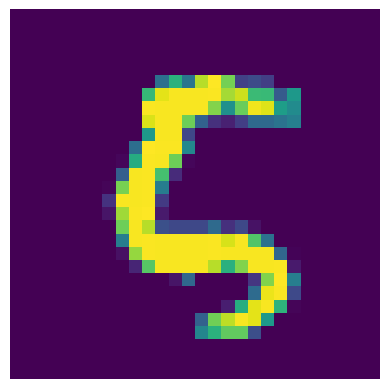

In [ ]:
teste = x_train[0][0]
plt.imshow(teste)
plt.axis('off')
plt.show()

In [ ]:
teste = tf.expand_dims(teste, axis = 0)
teste.shape

TensorShape([1, 28, 28, 1])

In [ ]:
encoded_image = Encoder_model.predict(teste)
print('Z : ' + str(encoded_image[0]))
print('Mean : ' + str(encoded_image[1]))
print('Log_Var : ' + str(encoded_image[2]))


2024-08-15 15:22:47.699422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-08-15 15:22:48.216257: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 15:22:48.216465: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 15:22:48.216482: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-08-15 15:22:48.216792: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 15:22:48.216879: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 1s 1s/step
Z : [[ 1.98149    -0.06550196]]
Mean : [[-0.05572234  0.0628576 ]]
Log_Var : [[-0.08412249 -0.02237741]]


2024-08-15 15:22:48.537383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Decoder

In [ ]:
def Decoder():

    latent_inputs = Input(shape=(LATENT_DIM,))
    x = Dense(7*7*64, activation='relu')(latent_inputs)
    x = Reshape((7,7,64))(x)

    x = Conv2DTranspose(64,(3,3), strides= 2, padding="same")(x)
    x = Conv2DTranspose(32,(3,3), strides= 2, padding="same")(x)
    x = Conv2DTranspose(1,(3,3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=latent_inputs, outputs=x, name='VAE-Decoder')
    return model

Decoder_model = Decoder()
Decoder_model.summary()

Model: "VAE-Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        

#### Testing Variational Decoder

1/1 [==============================] - 0s 257ms/step


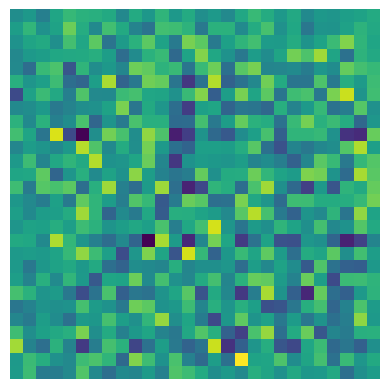

In [ ]:
#Zero Shot

Dencoded_image = Decoder_model.predict(encoded_image[0])
plt.imshow(Dencoded_image[0])
plt.axis('off')
plt.show()

## VAE Full Model

In [ ]:
def VAE():
    vae_inputs = Input(shape=(28, 28, 1))
    z, _, _ = Encoder_model(vae_inputs)
    outputs = Decoder_model(z)

    vae_model = Model(vae_inputs, outputs, name='VAE')
    return vae_model

VAE_model = VAE()
VAE_model.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 VAE-Encoder (Functional)    [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 VAE-Decoder (Functional)    (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
def customized_loss(y_true, y_pred, mean, log_var):
    # Loss que tenta aproximar os valores de cada pixel do correto
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2)))

    # Loss que tenta aproximar os valores da média e do desvio padrão dos pixels
    # Para isso, utiliza o logaritmo natural para evitar problemas com números negativos
    regression_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.square(mean)-tf.exp(log_var)),axis = 1))

    return reconstruction_loss + regression_loss

In [ ]:
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = Encoder_model(x_batch)
        y_pred = Decoder_model(z)
        loss = customized_loss(x_batch, y_pred, mean, log_var)

    gradients = recorder.gradient(loss, vae_model.trainable_weights)
    Adam(learning_rate = 1e-3).apply_gradients(zip(gradients, vae_model.trainable_weights))
    return loss

In [ ]:
def train(data, epochs):
    for epoch in tqdm(range(epochs)):
        print('Epoch: ',epoch+1)

        for step, x_batch in enumerate(data):
            loss = training_block(x_batch)
        print('Training Loss: ',loss)

In [ ]:
train(train_dataset, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1


## Testing

In [ ]:
scale=1
n=16

In [ ]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [ ]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=VAE_model.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1